In [64]:
from torch import nn
import torch
from torch.optim import AdamW
import numpy as np
import re
from nltk.tokenize import word_tokenize
import wikipediaapi
import matplotlib.pyplot as plt

In [42]:


def generate_data_skipgram(corpus, window_size, vocab_size, word_to_index):
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # Input word as index
                    all_in.append(word_to_index[word])
                    # Context word as one-hot
                    one_hot = np.zeros(vocab_size)
                    one_hot[word_to_index[words[i]]] = 1
                    all_out.append(one_hot)

    return np.array(all_in), np.array(all_out)

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.out = nn.Linear(embedding_dim, vocab_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        emb = self.embedding(x)
        out = self.out(emb)
        return self.softmax(out)


# Initialize the Wikipedia API for Finnish
user_agent = "YourAppName/1.0 (your.email@example.com)"
wiki = wikipediaapi.Wikipedia(language="fi", user_agent=user_agent)

def get_category_members(category_name, max_pages=10):
    category = wiki.page("Luokka:" + category_name)
    if not category.exists():
        print(f"Category '{category_name}' does not exist.")
        return []

    articles = []
    for member in category.categorymembers.values():
        if len(articles) >= max_pages:
            break
        if member.ns == 0:  # ns=0 indicates articles
            print(f"Fetching: {member.title}")
            articles.append(member.text)
    return articles

# Example: Fetch articles from the "Tekniikka" (Technology) category
finnish_articles = get_category_members("Puut", max_pages=100)



Fetching: Puu
Fetching: Aaltokielopuu
Fetching: Acrenamburana
Fetching: Adenanthera pavonina
Fetching: Afrikanemeropuu
Fetching: Afrikaniroko
Fetching: Afrikanrieskapuu
Fetching: Afzelia africana
Fetching: Akaasiat
Fetching: Akee
Fetching: Alabamantrumpettipuu
Fetching: Amblapuu
Fetching: Amrapuu
Fetching: Amurinkorkkipuu
Fetching: Amurinvaahtera
Fetching: Apachi
Fetching: Argania spinosa
Fetching: Aurinkosoihtupuu
Fetching: Bahamantemppelipuu
Fetching: Balsapuu
Fetching: Banianiviikuna
Fetching: Barbeyaceae
Fetching: Bengalinleiskupuu
Fetching: Brasiliankesalpinia
Fetching: Bursera graveolens
Fetching: Ceyloninmoringa
Fetching: Costaricanmakapuu
Fetching: Costaricansäkenepuu
Fetching: Coulteria cubensis
Fetching: Davidinvaahtera
Fetching: Dipentodontaceae
Fetching: Eupteleaceae
Fetching: Gaboninkopaalipuu
Fetching: Gaboninmarkiisipuu
Fetching: Gabonpuu
Fetching: Gomortega keule
Fetching: Gomortegaceae
Fetching: Guapira floribunda
Fetching: Haptanthus hazlettii
Fetching: Hartsiakaasia


In [51]:
def clean_wikipedia_text(text):
    text = re.sub(r"=+.*?=+", "", text)
    
    # Remove references like [1], [2]
    text = re.sub(r"\[\d+\]", "", text)
    
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    
    # Remove links (URLs)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    
    # Remove sections that are non-informative
    sections = ["See also", "References", "External links", "Further reading", "Katso myös", "Viitteet", "Lähteet"]
    for section in sections:
        text = re.sub(rf"== {section} ==.*", "", text, flags=re.DOTALL)

    # Remove special characters and numbers (retain only alphabetic characters and spaces)
    text = re.sub(r"[^a-zA-ZäöåÄÖÅ\s]", "", text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Clean all articles
corpus = [clean_wikipedia_text(article) for article in finnish_articles]
print(f"Cleaned {len(corpus)} articles.")

# Filter short sentences
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# Tokenize corpus into words
corpus = [word_tokenize(sentence.lower()) for sentence in corpus]

# Build vocabulary and word-to-index mapping
flat_corpus = [word for sentence in corpus for word in sentence]
unique_words = sorted(set(flat_corpus))
word_to_index = {word: idx for idx, word in enumerate(unique_words)}
vocab_size = len(unique_words)


# Generate skip-gram data
window_size = 2
X_skip, y_skip = generate_data_skipgram(corpus, window_size, vocab_size, word_to_index)
print(f"Input shape: {X_skip.shape}, Output shape: {y_skip.shape}")


Cleaned 100 articles.
Input shape: (70796,), Output shape: (70796, 6515)


In [60]:
y_skip

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [52]:
vocab_size

6515

In [53]:
list(word_to_index)[:100]

['a',
 'aaltoileva',
 'aaltokielopuu',
 'aaltokielopuun',
 'aaltokielopuusta',
 'aaltokielopuuta',
 'aamiaisella',
 'aamulla',
 'aarnio',
 'aasiaa',
 'aasialainen',
 'aasialaisen',
 'aasian',
 'aasiassa',
 'aasiasta',
 'aavistuksen',
 'abatsi',
 'abyssinica',
 'acacia',
 'acer',
 'acreana',
 'acrenamburana',
 'acrenamburanaa',
 'acrenamburanan',
 'addiktoivaa',
 'adenanthera',
 'adenocalyx',
 'african',
 'africana',
 'africanan',
 'afrikan',
 'afrikanemeropuu',
 'afrikanemeropuun',
 'afrikanemeropuuta',
 'afrikaniroko',
 'afrikanrieskapuu',
 'afrikanrieskapuun',
 'afrikanrieskapuut',
 'afrikassa',
 'afrikkaa',
 'afrikkaan',
 'afrikkalainen',
 'afrikkalaisessa',
 'afxelia',
 'afzelia',
 'agriculture',
 'agrimonia',
 'ahvenanmaalla',
 'aidan',
 'aiemmin',
 'aiheesta',
 'aihetta',
 'aiheutta',
 'aiheuttaa',
 'aiheuttama',
 'aiheuttamia',
 'aiheuttamille',
 'aiheuttanut',
 'aiheuttavan',
 'aiheuttavat',
 'aikaan',
 'aikaisemmin',
 'aikaisen',
 'aikaisin',
 'aikaisintaan',
 'aikana',
 'aika

In [74]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the Word2Vec model
embedding_dim = 500
batch_size = 32
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.to(device)
optim = AdamW(word2vec.parameters(), lr=3e-3)
loss_f = nn.CrossEntropyLoss()

# Convert data to PyTorch tensors
X_skip = torch.tensor(X_skip, dtype=torch.long, device=device)  # Input indices
y_skip = torch.tensor(y_skip, dtype=torch.float, device=device)  # One-hot encoded targets

# Training loop

/var/folders/wh/jwc03s_96l93f7jyblm_8q9m0000gn/T/ipykernel_10686/3432276656.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_skip = torch.tensor(X_skip, dtype=torch.long, device=device)  # Input indices
/var/folders/wh/jwc03s_96l93f7jyblm_8q9m0000gn/T/ipykernel_10686/3432276656.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_skip = torch.tensor(y_skip, dtype=torch.float, device=device)  # One-hot encoded targets


In [75]:
losses = []
iters = 2000
for i in range(iters):  # Number of training steps
    # Randomly sample a batch of data
    norm_losses = []
    idx = np.random.choice(len(X_skip), size=batch_size, replace=True)
    
    batch_x, batch_y = X_skip[idx], y_skip[idx]

    # Zero gradients from the previous step
    optim.zero_grad()

    # Forward pass
    out = word2vec(batch_x)

    # Compute the loss
    loss = loss_f(out, batch_y)  # Convert one-hot to class indices

    # Backward pass and optimization
    loss.backward()
    optim.step()
    norm_losses.append(loss.item())

    # Print loss every 10 iterations
    if i % 300 == 0:
        losses.append(sum(norm_losses) / 300)
        print(f"Iteration {i}, Loss: {loss.item():.4f}")

Iteration 0, Loss: 8.7819
Iteration 100, Loss: 8.7808
Iteration 200, Loss: 8.7597
Iteration 300, Loss: 8.7492
Iteration 400, Loss: 8.7404
Iteration 500, Loss: 8.7335
Iteration 600, Loss: 8.7172
Iteration 700, Loss: 8.6570
Iteration 800, Loss: 8.6570
Iteration 900, Loss: 8.7195
Iteration 1000, Loss: 8.7480
Iteration 1100, Loss: 8.7195
Iteration 1200, Loss: 8.7508
Iteration 1300, Loss: 8.6832
Iteration 1400, Loss: 8.6959
Iteration 1500, Loss: 8.6569
Iteration 1600, Loss: 8.7508
Iteration 1700, Loss: 8.6259
Iteration 1800, Loss: 8.6280
Iteration 1900, Loss: 8.7012


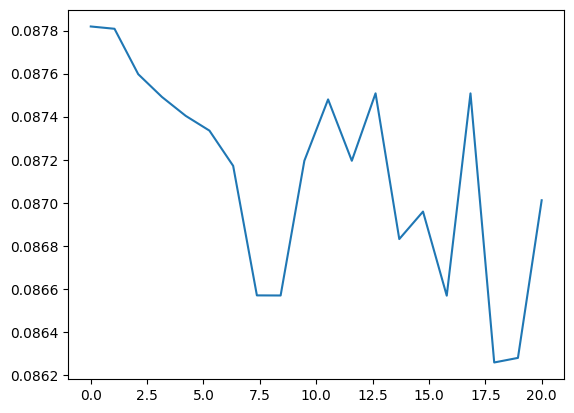

In [76]:
plt.plot(np.linspace(0, len(losses), len(losses)), losses)

In [56]:
torch.save({
    'model_state_dict': word2vec.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'word_to_index': word_to_index,  # Save word-to-index mapping for reuse
}, "word2vec_full_skipgram.pt")
print("Full training state saved as word2vec_full_skipgram.pt")

Full training state saved as word2vec_full_skipgram.pt
